In [83]:
import skfmm
from scipy.ndimage import distance_transform_edt
from scipy.signal import convolve2d
from main import *

import pandas as pd

from tqdm import tqdm

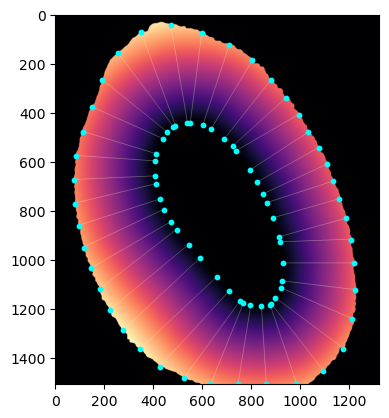

In [84]:
donut, res = get_picture2D('donut.tif')
point, _ = get_picture('point.tif')
height, width = donut.shape

donut_mask = donut != 0

# we should have only ventricle and outside regions
labeled, n = label(~ donut_mask)

if n != 2:
    raise ValueError('problem with masks, too many regions')

# outside label is the label of the pixel on the top left
outside_label = labeled[(0,0)]
outside_mask = labeled == outside_label
# ventricle is the other region
ventr_mask = (labeled != outside_label) & (~ donut_mask)

# show_pic(donut_mask, 'donut')

# calculating distance from ventricle
distance = np.zeros_like(donut, dtype=np.float64)
# keeping it only in the area of the donut
distance[donut_mask] = distance_transform_edt(~ventr_mask, sampling= res)[donut_mask]

# max value in the distance pic
max_dist = np.max(distance)

# find center of the ventricle
ventr_coords = center_of_mass(ventr_mask)

# find point in the reference pic
point_mask = point != 0
point_coords = center_of_mass(point_mask)


dx = point_coords[0] - ventr_coords[0]
dy = point_coords[1] - ventr_coords[1]
angle_0 = math.atan2(dy, dx)

max_length = np.linalg.norm(donut.shape)
# how many angles
n_angles = 40

results = pd.DataFrame(columns = ['angle_r', 'angle_d', 'thickness', 'ext_x', 'ext_y', 'vent_x', 'vent_y'])

test_img = distance.copy()

for i in range(n_angles):

    # angle of the ray
    a = 2*math.pi / n_angles * i + angle_0
    
    line_pixels = get_ray_pixels(donut, ventr_coords, a, res)

    cols = line_pixels[:,0]
    rows = line_pixels[:,1]



    # add radial picture line on top of picture
    # test_img[rows, cols] = max_dist

    # find the max ventricle distance along line
    current_thickness = np.max(distance[rows, cols])
    # where is the max distance along line
    current_index = np.argmax(distance[rows, cols])
    current_coords = [int(cols[current_index]), int(rows[current_index])]

    # circe centered in current point
    circ_pixels = get_circle_pixels(distance, current_coords, current_thickness, res)
    rows = circ_pixels[:,0]
    cols = circ_pixels[:,1]

    # add circle on top of picture
    # test_img[rows, cols] = max_dist

    # I need to set the pixels outside the tissue at some max value
    fake_distance = distance.copy()
    fake_distance[outside_mask] = max_dist
    vent_index = np.argmin(fake_distance[rows, cols])
    vent_coords = [int(cols[vent_index]), int(rows[vent_index])]

    r_line, c_line = get_line_pixels(current_coords, vent_coords)
    test_img[r_line, c_line] = max_dist

    results.loc[len(results)] = [a-angle_0, np.degrees(a-angle_0), current_thickness, *current_coords, *vent_coords]

# print(results)

plt.imshow(test_img, cmap = 'magma')
plt.scatter(results['ext_x'], results['ext_y'], s = 10, color = 'cyan')
plt.scatter(results['vent_x'], results['vent_y'], s = 10, color = 'cyan')
plt.show()

results.to_csv('result.csv')

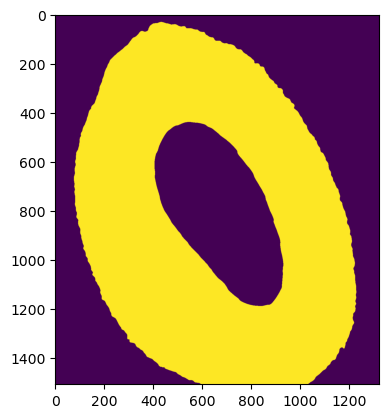

In [85]:
plt.imshow(donut)

# weird shape times 🎉

## pictures loading

### the test ventricle

In [100]:
donut, _ = get_picture2D('test_vent.tif')
res = (1,1)

point = np.zeros_like(donut).astype(bool)
test_coord = (point.shape[0] // 2, point.shape[1] - 1)
point[test_coord] = True

c:\Users\USUARIO\anaconda3\envs\image-env\Lib\site-packages\aicsimageio\readers\tiff_reader.py:148: UserWarning: Could not parse tiff pixel size: 'unit'
  warnings.warn(f"Could not parse tiff pixel size: {e}")


### actual picture

In [175]:
donut, res = get_picture2D('donut.tif')
point, _ = get_picture2D('point.tif')

In [210]:
donut, res = get_picture2D('pics/C1-29-08-2025 E12 R1 f - E4 FGF2-EdU+E6 FGF2 - EdU 647 - GFP+HuCD 488 - SOX2 555 - M-2.tif')
point, _ = get_picture2D('pics/C1-29-08-2025 E12 R1 f - E4 FGF2-EdU+E6 FGF2 - EdU 647 - GFP+HuCD 488 - SOX2 555 - M-3.tif')

In [211]:
donut = np.pad(donut, pad_width=5, mode='constant', constant_values=0)
point = np.pad(point, pad_width=5, mode='constant', constant_values=0)

977.92 1594.81
smoothing factor = 23.41


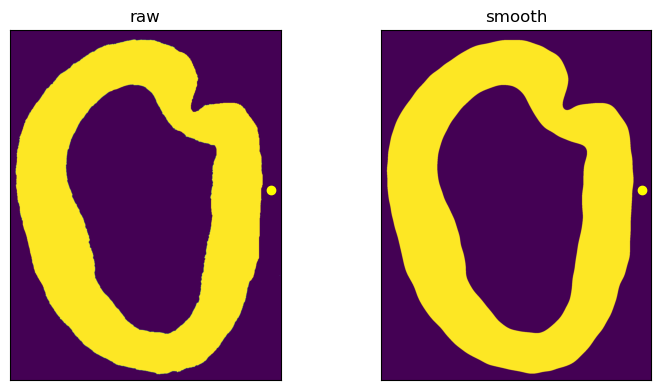

In [212]:
point_mask = point != 0
point_coords = center_of_mass(point_mask)

print(f'{point_coords[0]:.2f} {point_coords[1]:.2f}')


fig, axs = plt.subplots(1, 2, figsize = (8,4))
axs[0].set_title('raw')
axs[0].imshow(donut)

########################################
donut = smoothing(donut)
########################################

axs[1].set_title('smooth')
axs[1].imshow(donut)


for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

    ax.scatter(*point_coords[::-1], c = '#ffff00')

plt.tight_layout()

### get the ventricle

In [213]:
height, width = donut.shape

donut_mask = donut != 0

# we should have only ventricle and outside regions
labeled, n = label(~ donut_mask)

if n != 2:
    raise ValueError('problem with masks, too many regions')

# outside label is the label of the pixel on the top left
outside_label = labeled[(0,0)]
outside_mask = labeled == outside_label
# ventricle is the other region
ventr_mask = (labeled != outside_label) & (~ donut_mask)

center_of_mass(ventr_mask)

(np.float64(1079.8923143202496), np.float64(812.5207914767808))

In [214]:
r_df = pd.DataFrame()

## finding the edge

### inside edge pixels

In [215]:
edge_in = find_edge(ventr_mask)

coords_in_np = np.argwhere(edge_in)
coords_in = [c for c in coords_in_np]

In [216]:
def find_angle(p,q):

    dx = p[0] - q[0]
    dy = p[1] - q[1]
    
    return math.atan2(dy, dx)

In [217]:
def ordered_edge_points(edge):
    coords_in_np = np.argwhere(edge)


    start_p = tuple(coords_in_np[0])
    ordered_p = [start_p]

    while len(ordered_p) < coords_in_np.shape[0]:

        current_p = ordered_p[-1]

        neighborhood = edge[current_p[0]-1:current_p[0]+2, current_p[1]-1:current_p[1]+2]
        
        # the set contains the considered point and the two 
        neighbors = [tuple(int(c) for c in k) for k in np.argwhere(neighborhood)]

        neighbors.remove((1,1))

        # these are the only possible configurations for the first pixel
        # ---    ---    ---
        # -xx    -xx    -x-
        # x--    -x-    x-x
        # the only possible anticlockwise pixels are (2,0) or (2,1)
        # 
        if len(ordered_p) == 1:
            if (2,0) in neighbors:
                next_p = (2,0)
            elif (2,1) in neighbors:
                next_p = (2,1)
            else:
                raise ValueError('something wrong with the edge')
            
            # we need to convert the point coordinates back to the absolute reference
            next_p = np.array([c-1 for c in next_p])
            next_p = tuple(current_p + next_p)
        else:
            for p in neighbors:
                # we need to convert the point coordinates back to the absolute reference
                p = np.array([c-1 for c in p])
                p = tuple(current_p + p)

                if p not in ordered_p:
                    next_p = p
                    break
            else:
                raise ValueError('something wrong with the visited pixels')

        ordered_p.append(next_p)
    
    return ordered_p


### outside edge pixels

In [218]:
edge_out = find_edge(outside_mask)

coords_out_np = np.argwhere(edge_out).astype(int)
coords_out = [tuple(map(int,c)) for c in coords_out_np]


r_df['p_out'] = coords_out

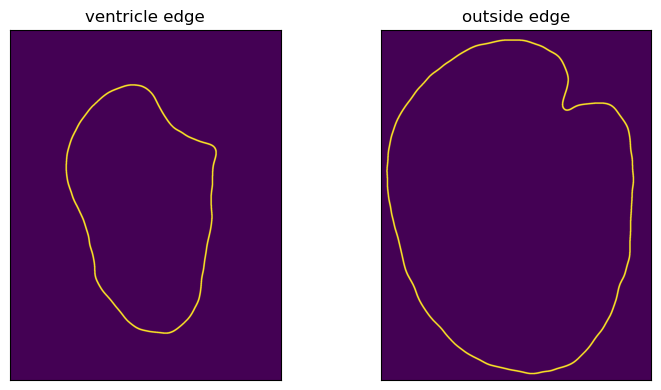

In [219]:
fig, axs = plt.subplots(1,2, figsize = (8,4))

axs[0].set_title('ventricle edge')
axs[0].imshow(thickening(edge_in))

axs[1].set_title('outside edge')
axs[1].imshow(thickening(edge_out))

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()

### all the outside pixels have a distance

In [220]:
tissue = np.ma.MaskedArray(~edge_in, outside_mask)

distance = skfmm.distance(tissue, dx=res)

r_df['dist'] = [distance[tuple(c)] for c in r_df['p_out']]

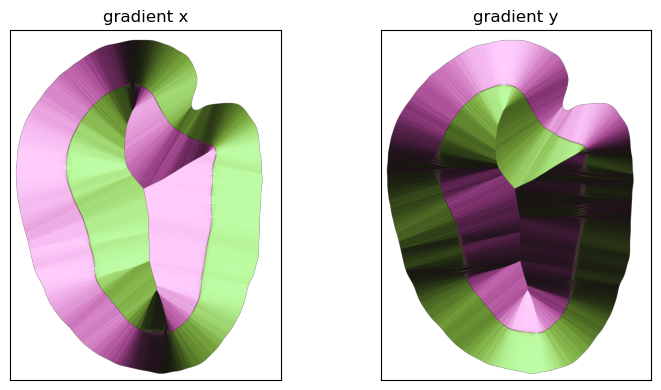

In [221]:
gy, gx = np.gradient(distance)

fig, axs = plt.subplots(1,2, figsize = (8,4))

axs[0].set_title('gradient x')
axs[0].imshow(gx, cmap='vanimo')

axs[1].set_title('gradient y')
axs[1].imshow(gy, cmap='vanimo')

for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()

## follow the gradient

In [222]:
reference_in_list = []

for i, coord_out in enumerate(tqdm(coords_out_np)):

    coord_in, result_list = follow_gradient(distance, coord_out, edge_in, max_steps=1000)

    reference_in_list.append(coord_in)

r_df['p_in'] = reference_in_list


100%|██████████| 5331/5331 [04:38<00:00, 19.13it/s]


## find the reference angle

In [223]:
# find center of the ventricle
ventr_coords = center_of_mass(ventr_mask)

# find point in the reference pic
point_mask = point != 0
point_coords = center_of_mass(point_mask)

dx = point_coords[0] - ventr_coords[0]
dy = point_coords[1] - ventr_coords[1]
angle_0 = math.atan2(dy, dx)

In [224]:
for index, row in r_df.iterrows():
    coord_in = row['p_in']

    dx = coord_in[0] - ventr_coords[0]
    dy = coord_in[1] - ventr_coords[1]

    current_angle = math.atan2(dy, dx) - angle_0

    r_df.loc[index, 'angle'] = (current_angle / np.pi * 180) % 360


In [225]:
r_df.head(10)

,p_out,dist,p_in,angle
0,"(61, 752)",882.145698,"(335, 764)",86.299962
1,"(61, 753)",881.998627,"(335, 763)",86.376548
2,"(61, 754)",881.863218,"(335, 764)",86.299962
3,"(61, 755)",881.739475,"(335, 764)",86.299962
4,"(61, 756)",881.627404,"(335, 763)",86.376548
5,"(61, 757)",881.527009,"(335, 764)",86.299962
6,"(61, 758)",881.438290,"(335, 763)",86.376548
7,"(61, 759)",881.361245,"(335, 763)",86.376548
8,"(61, 760)",881.295856,"(335, 764)",86.299962
9,"(61, 761)",881.242059,"(335, 764)",86.299962


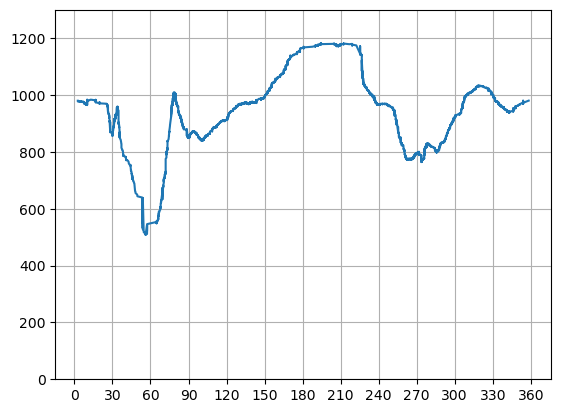

In [226]:
plot_df = r_df.sort_values('angle')

plt.plot(plot_df['angle'], plot_df['dist'])
plt.ylim(0, r_df['dist'].max()*1.1)
plt.xticks(np.arange(0,390,30))
plt.grid()

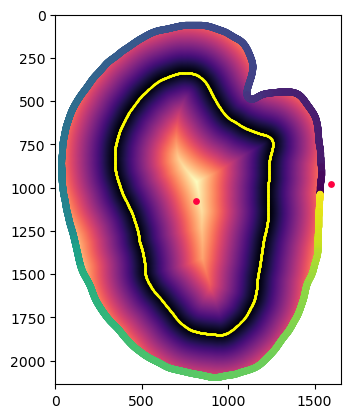

In [227]:
plt.imshow(distance, cmap='magma')
plt.scatter(*df_col_to_points(coords_out), s=15, c=r_df['angle'])
plt.scatter(*df_col_to_points(coords_in), s=0.1, c='yellow')

plt.scatter(*point_coords[1::-1], s=15, color = "#ff0040")
plt.scatter(*ventr_coords[::-1], s=15, color = "#ff0040")

In [228]:
output_df = pd.DataFrame()

gap = 5

angles = range(0, 360, gap)
output_df['angle'] = angles

# adding a padding to get the angles around the whole circle
temp_low_padding = r_df.loc[r_df['angle'] > 360-gap].copy()
temp_low_padding['angle'] = temp_low_padding['angle'] - 360

temp_upp_padding = r_df.loc[r_df['angle'] < gap].copy()
temp_upp_padding['angle'] = temp_upp_padding['angle'] + 360


temp_r_df = pd.concat((r_df, temp_low_padding, temp_upp_padding), ignore_index=True)

for i, a in enumerate(angles):
    current_points = temp_r_df.loc[(temp_r_df['angle'] > a - gap) & (temp_r_df['angle'] < a + gap)]

    output_df.loc[i, 'thickness'] = current_points['dist'].mean()


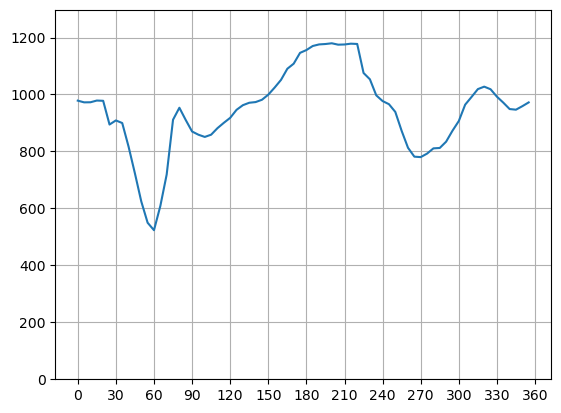

In [229]:
plt.plot(output_df['angle'], output_df['thickness'])
plt.ylim(0, output_df['thickness'].max()*1.1)

plt.xticks(np.arange(0,390,30))
plt.grid()

In [230]:
output_df.head()

,angle,thickness
0,0,978.328825
1,5,972.300999
2,10,972.610362
3,15,978.657011
4,20,977.731054


In [231]:
ordered_edge_out = ordered_edge_points(edge_out)

starting_point = r_df.loc[r_df['angle'] == r_df['angle'].min()].iloc[0]['p_out']


i = ordered_edge_out.index(starting_point)
ordered_edge_out = ordered_edge_out[i:] + ordered_edge_out[:i]


order_map = {p: i for i, p in enumerate(ordered_edge_out)}
r_df['order'] = r_df['p_out'].map(order_map)

r_df = r_df.sort_values('order').reset_index(drop=True)

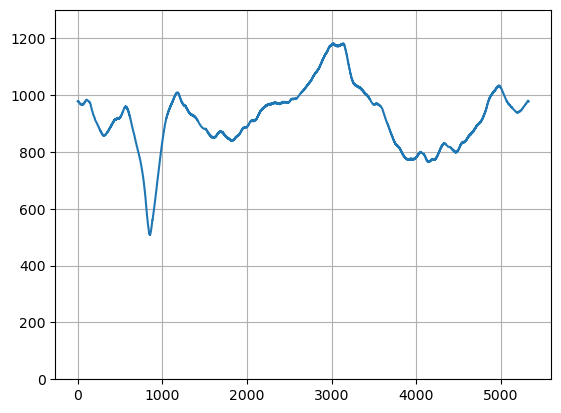

In [232]:
plt.plot(r_df['dist'])
plt.ylim(0, r_df['dist'].max()*1.1)
plt.grid()

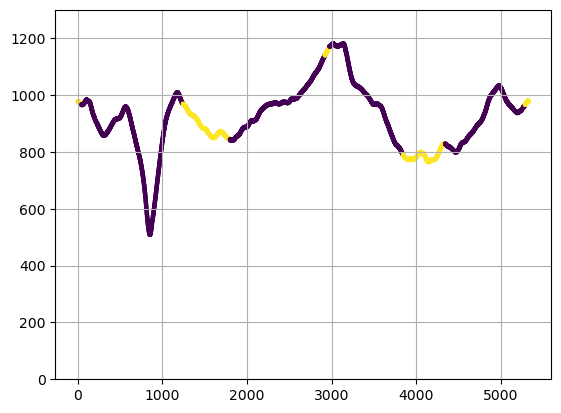

In [ ]:
r_df['c_map'] = (0.5*np.cos(4*r_df['angle']/180*np.pi) + 0.5) ** 2

plt.scatter(r_df['order'], r_df['dist'], s=5, c = r_df['c_map'])
plt.ylim(0, r_df['dist'].max()*1.1)
plt.grid()

In [234]:
def analyze_thick(donut, medial_poin, res, angle_res=5, smooth = True, plot = True):
    # finding medial_point
    point_mask = medial_poin != 0
    point_coords = center_of_mass(point_mask)

    print(f'{point_coords[0]:.2f} {point_coords[1]:.2f}')


    if smooth:
        if plot:
            fig, axs = plt.subplots(1, 2, figsize = (8,4))
            axs[0].set_title('raw')
            axs[0].imshow(donut)

        ########################################
        donut = smoothing(donut)
        ########################################

        if plot:
            axs[1].set_title('smooth')
            axs[1].imshow(donut)

            for ax in axs:
                ax.set_xticks([])
                ax.set_yticks([])

                ax.scatter(*point_coords[::-1], c = '#ffff00')

            plt.tight_layout()
            plt.show()
    

    donut_mask = donut != 0

    # we should have only ventricle and outside regions
    labeled, n = label(~ donut_mask)

    if n != 2:
        raise ValueError('problem with masks, too many regions')

    # outside label is the label of the pixel on the top left
    outside_label = labeled[(0,0)]
    outside_mask = labeled == outside_label
    # ventricle is the other region
    ventr_mask = (labeled != outside_label) & (~ donut_mask)

    r_df = pd.DataFrame()
    
    # edge inside
    edge_in = find_edge(ventr_mask)
    coords_in_np = np.argwhere(edge_in)
    coords_in = [c for c in coords_in_np]

    # edge outside
    edge_out = find_edge(outside_mask)
    coords_out_np = np.argwhere(edge_out).astype(int)
    coords_out = [tuple(map(int,c)) for c in coords_out_np]

    r_df['p_out'] = coords_out

    if plot:
        fig, axs = plt.subplots(1,2, figsize = (8,4))

        axs[0].set_title('ventricle edge')
        axs[0].imshow(thickening(edge_in))

        axs[1].set_title('outside edge')
        axs[1].imshow(thickening(edge_out))

        for ax in axs:
            ax.set_xticks([])
            ax.set_yticks([])

        plt.tight_layout()
        plt.show()
    
    # calculate geodesic distance
    tissue = np.ma.MaskedArray(~edge_in, outside_mask)
    distance = skfmm.distance(tissue, dx=res)

    r_df['dist'] = [distance[tuple(c)] for c in r_df['p_out']]

    if plot:
        gy, gx = np.gradient(distance)

        fig, axs = plt.subplots(1,2, figsize = (8,4))

        axs[0].set_title('gradient x')
        axs[0].imshow(gx, cmap='vanimo')

        axs[1].set_title('gradient y')
        axs[1].imshow(gy, cmap='vanimo')

        for ax in axs:
            ax.set_xticks([])
            ax.set_yticks([])

        plt.tight_layout()
        plt.show()

    # finding the ventricle reference
    reference_in_list = []
    for i, coord_out in enumerate(tqdm(coords_out_np)):

        coord_in, result_list = follow_gradient(distance, coord_out, edge_in, max_steps=1000)

        reference_in_list.append(coord_in)
    r_df['p_in'] = reference_in_list

    # find center of the ventricle
    ventr_coords = center_of_mass(ventr_mask)

    # find point in the reference pic
    point_mask = point != 0
    point_coords = center_of_mass(point_mask)

    dx = point_coords[0] - ventr_coords[0]
    dy = point_coords[1] - ventr_coords[1]
    angle_0 = math.atan2(dy, dx)

    for index, row in r_df.iterrows():
        coord_in = row['p_in']

        dx = coord_in[0] - ventr_coords[0]
        dy = coord_in[1] - ventr_coords[1]

        current_angle = math.atan2(dy, dx) - angle_0

        r_df.loc[index, 'angle'] = (current_angle / np.pi * 180) % 360
    
    if plot:
        plt.imshow(distance, cmap='magma')
        plt.scatter(*df_col_to_points(coords_out), s=15, c=r_df['angle'])
        plt.scatter(*df_col_to_points(coords_in), s=0.1, c='yellow')

        plt.scatter(*point_coords[1::-1], s=15, color = "#ff0040")
        plt.scatter(*ventr_coords[::-1], s=15, color = "#ff0040")
        plt.show()

    output_df = pd.DataFrame()

    angle_res = 5

    angles = range(0, 360, angle_res)
    output_df['angle'] = angles

    # adding a padding to get the angles around the whole circle
    temp_low_padding = r_df.loc[r_df['angle'] > 360-angle_res].copy()
    temp_low_padding['angle'] = temp_low_padding['angle'] - 360

    temp_upp_padding = r_df.loc[r_df['angle'] < angle_res].copy()
    temp_upp_padding['angle'] = temp_upp_padding['angle'] + 360


    temp_r_df = pd.concat((r_df, temp_low_padding, temp_upp_padding), ignore_index=True)

    for i, a in enumerate(angles):
        current_points = temp_r_df.loc[(temp_r_df['angle'] > a - angle_res) & (temp_r_df['angle'] < a + angle_res)]

        output_df.loc[i, 'thickness'] = current_points['dist'].mean()
    
    if plot:
        plt.plot(output_df['angle'], output_df['thickness'])
        plt.ylim(0, output_df['thickness'].max()*1.1)

        plt.xticks(np.arange(0,390,30))
        plt.grid()
    
    return output_df


200.00 399.00
smoothing factor = 4.56


c:\Users\USUARIO\anaconda3\envs\image-env\Lib\site-packages\aicsimageio\readers\tiff_reader.py:148: UserWarning: Could not parse tiff pixel size: 'unit'
  warnings.warn(f"Could not parse tiff pixel size: {e}")


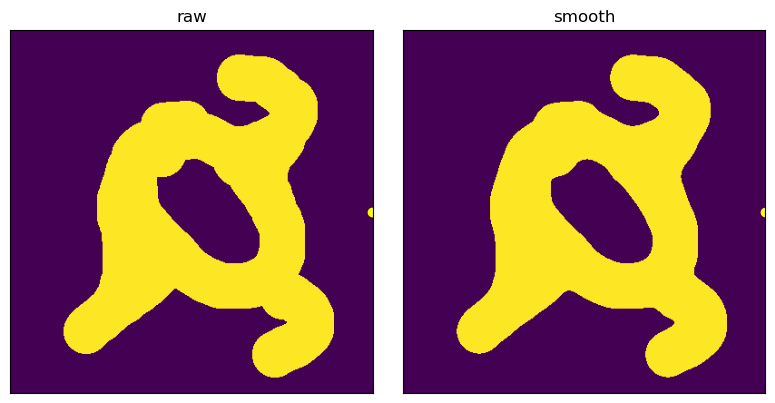

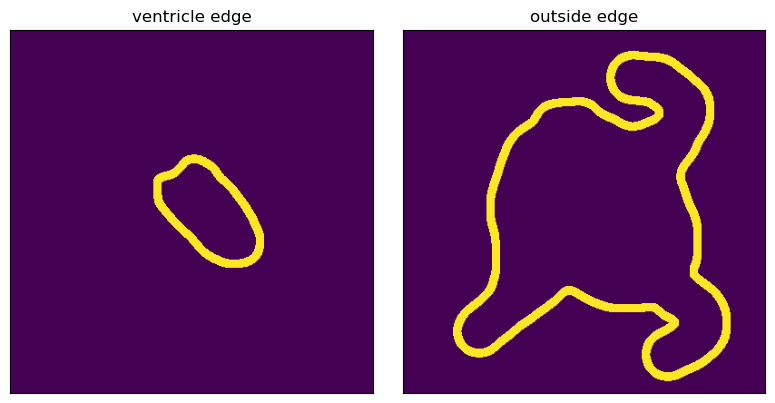

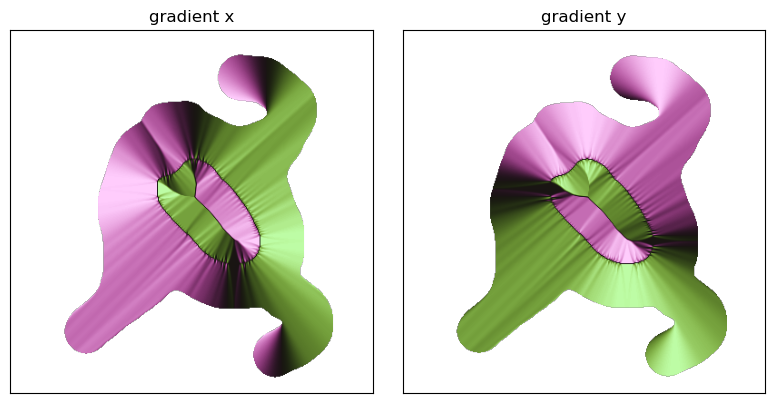

100%|██████████| 1239/1239 [00:04<00:00, 301.95it/s]


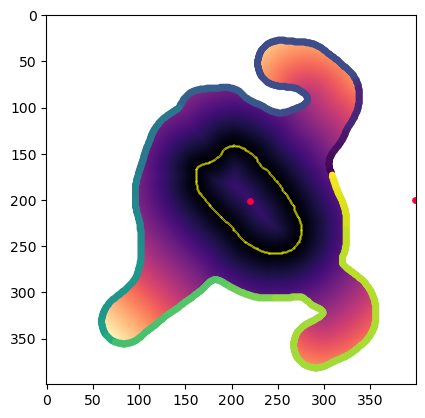

,angle,thickness
0,0,52.971351
1,5,53.485700
2,10,57.773577
3,15,62.386049
4,20,70.994007
...,...,...
67,335,49.110230
68,340,49.304916
69,345,49.687575
70,350,50.344235


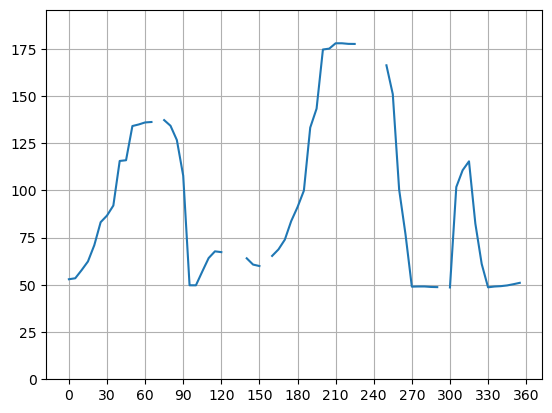

In [235]:
tissue, _ = get_picture2D('test_vent.tif')
res = (1,1)

point = np.zeros_like(tissue).astype(bool)
test_coord = (point.shape[0] // 2, point.shape[1] - 1)
point[test_coord] = True

analyze_thick(tissue, point, res)